In [43]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [3]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('student_health_fitness_dataset.csv')
df.sample(10)

Saving student_health_fitness_dataset.csv to student_health_fitness_dataset.csv


,Student ID,Age,Gender,Blood Oxygen Level (%),Body Temperature (°C),Heart Rate (bpm),Physical Activity Level (METs),Sleep Duration (hours),Hydration Level (liters),Stress Level (1-10),Brain Function,Emotional Control,Cognitive Processes,Overall Health Score
479,S0480,17,Male,99.78,37.04,99,6.79,7.53,2.07,5,0.76,0.45,0.94,54.23
220,S0221,18,Other,99.94,36.71,87,5.51,8.00,3.05,7,0.66,0.52,0.66,58.40
310,S0311,15,Other,97.58,36.86,79,7.08,6.48,2.94,2,0.65,0.41,0.87,58.66
114,S0115,15,Male,95.62,36.56,65,4.99,7.37,2.51,7,0.55,0.57,0.86,59.72
316,S0317,16,Other,96.92,36.14,61,6.75,8.91,2.32,1,0.80,0.69,0.63,64.35
465,S0466,15,Male,99.26,36.85,94,6.38,5.95,3.10,4,0.90,0.78,0.78,54.87
18,S0019,18,Other,96.18,36.71,62,9.65,5.21,3.16,7,0.74,0.74,0.57,59.51
447,S0448,18,Female,95.42,36.69,81,8.88,7.90,2.44,8,0.78,0.35,0.65,57.73
80,S0081,16,Female,97.51,36.02,91,7.75,7.29,2.19,5,0.68,0.53,0.74,54.92
83,S0084,18,Male,96.21,36.78,72,2.36,8.14,2.42,7,0.50,0.68,0.87,59.02


In [4]:
features = df.iloc[:,3:8]
features

,Blood Oxygen Level (%),Body Temperature (°C),Heart Rate (bpm),Physical Activity Level (METs),Sleep Duration (hours)
0,97.78,37.38,72,6.98,7.75
1,95.54,36.75,81,6.22,8.98
2,99.66,36.82,82,6.89,6.87
3,97.26,37.25,95,8.93,7.89
4,98.67,36.81,69,7.84,6.98
...,...,...,...,...,...
495,97.89,36.87,88,9.77,7.50
496,95.26,36.92,65,7.99,6.76
497,96.28,37.09,98,6.67,6.95
498,98.19,37.14,70,4.61,8.84


In [5]:
features.isnull().sum()

,0
Blood Oxygen Level (%),0
Body Temperature (°C),0
Heart Rate (bpm),0
Physical Activity Level (METs),0
Sleep Duration (hours),0


In [54]:
# Label anomaly based on clinical range
features["hr_anomaly"] = (
    (features["Heart Rate (bpm)"] < 65) |
    (features["Heart Rate (bpm)"] > 95) |
    (features["Blood Oxygen Level (%)"] < 90) |
    (features["Physical Activity Level (METs)"] > 8)
).astype(int)

# Feature matrix and labels
X = features[["Heart Rate (bpm)", "Blood Oxygen Level (%)", "Physical Activity Level (METs)"]]
y = features["hr_anomaly"]

# Train-test split (with reproducibility)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
from sklearn.metrics import classification_report, accuracy_score
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        43

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Accuracy: 1.0


In [55]:
scaler = MinMaxScaler()
hr_scaled = scaler.fit_transform(features["Heart Rate (bpm)"].values.reshape(-1, 1))

# Create sequences of 10 steps
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(hr_scaled)

# ❗ Fix shape for LSTM: (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Define and train LSTM
model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(X.shape[1], 1)),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
print("X shape:", X.shape)  # should be (num_samples, 10, 1)
print("y shape:", y.shape)  # should be (num_samples, 1)
model.fit(X, y, epochs=20, batch_size=32)

X shape: (490, 10, 1)
y shape: (490, 1)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2667
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1010
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0906
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0923
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0899
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0924
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0887
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0876
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0899
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0846
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0869
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0858
Epoch 13/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0886
Epoch 14/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0897
Epoch 15/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0874
Epoch 16/20
16/16 ━━━━━━━━━━━━

In [40]:
"""
predicted = model.predict(X)
predicted = scaler.inverse_transform(predicted)
actual = scaler.inverse_transform(y.reshape(-1, 1))



plt.figure(figsize=(10,5))
plt.plot(actual, label='Actual')
plt.plot(predicted, label='Predicted')
plt.title("Heart Rate Prediction")
plt.xlabel("Time")
plt.ylabel("BPM")
plt.legend()
plt.show()
"""


'\npredicted = model.predict(X)\npredicted = scaler.inverse_transform(predicted)\nactual = scaler.inverse_transform(y.reshape(-1, 1))\n\nimport matplotlib.pyplot as plt\n\nplt.figure(figsize=(10,5))\nplt.plot(actual, label=\'Actual\')\nplt.plot(predicted, label=\'Predicted\')\nplt.title("Heart Rate Prediction")\nplt.xlabel("Time")\nplt.ylabel("BPM")\nplt.legend()\nplt.show()\n'

In [56]:
features["hr_anomaly"] = (
    (features["Heart Rate (bpm)"] < 65) |
    (features["Heart Rate (bpm)"] > 95) |
    (features["Blood Oxygen Level (%)"] < 90) |
    (features["Physical Activity Level (METs)"] > 8)
).astype(int)
features["hr_anomaly"].value_counts()


,count
hr_anomaly,
0,290
1,210


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


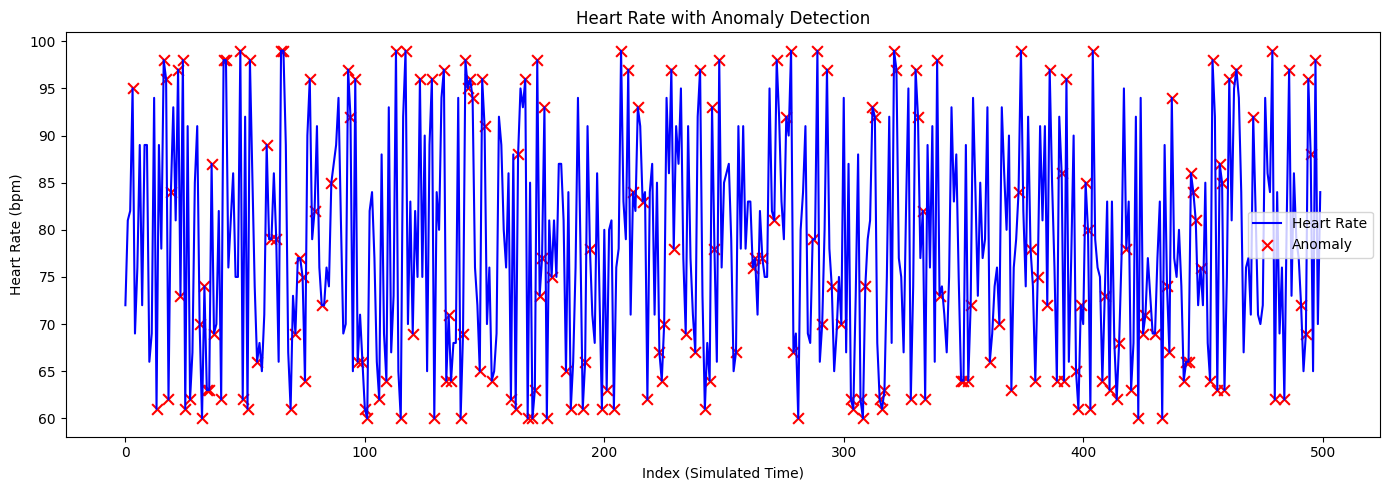

In [57]:
features["predicted_anomaly"] = model.predict(
    features[["Heart Rate (bpm)", "Blood Oxygen Level (%)", "Physical Activity Level (METs)"]]
)

# Use index as time
plt.figure(figsize=(14, 5))
plt.plot(features.index, features["Heart Rate (bpm)"], label="Heart Rate", color="blue")

# Highlight anomalies
plt.scatter(features.index[features["hr_anomaly"] == 1],
            features["Heart Rate (bpm)"][features["hr_anomaly"] == 1],
            color="red", label="Anomaly", marker="x", s=60)

plt.title("Heart Rate with Anomaly Detection")
plt.xlabel("Index (Simulated Time)")
plt.ylabel("Heart Rate (bpm)")
plt.legend()
plt.tight_layout()
plt.show()

In [64]:
import time

for i, row in features.iterrows():
    hr = row["Heart Rate (bpm)"]
    spo2 = row["Blood Oxygen Level (%)"]
    met = row["Physical Activity Level (METs)"]

    status = "✔️ Normal"

    if hr < 65 or hr > 95:
        status = "⚠️ HR Anomaly"
    elif spo2 < 90:
        status = "⚠️ SpO₂ Anomaly"
    elif met > 8:
        status = "⚠️ Activity Anomaly"

    print(f"HR: {hr} bpm | SpO₂: {spo2}% | METs: {met} → {status}")
    time.sleep(0.2)  # optional delay






HR: 72.0 bpm | SpO₂: 97.78% | METs: 6.98 → ✔️ Normal
HR: 81.0 bpm | SpO₂: 95.54% | METs: 6.22 → ✔️ Normal
HR: 82.0 bpm | SpO₂: 99.66% | METs: 6.89 → ✔️ Normal
HR: 95.0 bpm | SpO₂: 97.26% | METs: 8.93 → ⚠️ Activity Anomaly
HR: 69.0 bpm | SpO₂: 98.67% | METs: 7.84 → ✔️ Normal
HR: 76.0 bpm | SpO₂: 97.51% | METs: 5.72 → ✔️ Normal
HR: 89.0 bpm | SpO₂: 98.02% | METs: 5.43 → ✔️ Normal
HR: 72.0 bpm | SpO₂: 96.51% | METs: 6.94 → ✔️ Normal
HR: 89.0 bpm | SpO₂: 96.0% | METs: 5.37 → ✔️ Normal
HR: 89.0 bpm | SpO₂: 97.71% | METs: 5.39 → ✔️ Normal
HR: 66.0 bpm | SpO₂: 97.2% | METs: 1.64 → ✔️ Normal
HR: 69.0 bpm | SpO₂: 96.95% | METs: 2.98 → ✔️ Normal
HR: 94.0 bpm | SpO₂: 98.36% | METs: 5.65 → ✔️ Normal
HR: 61.0 bpm | SpO₂: 98.45% | METs: 8.49 → ⚠️ HR Anomaly
HR: 89.0 bpm | SpO₂: 95.23% | METs: 3.87 → ✔️ Normal
HR: 78.0 bpm | SpO₂: 96.69% | METs: 5.94 → ✔️ Normal
HR: 98.0 bpm | SpO₂: 97.06% | METs: 4.43 → ⚠️ HR Anomaly
HR: 96.0 bpm | SpO₂: 95.48% | METs: 2.39 → ⚠️ HR Anomaly
HR: 62.0 bpm | SpO₂: 96.18

KeyboardInterrupt: 